In [ ]:
from PIL import Image
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter, distance_transform_edt
from skimage.morphology import disk, binary_erosion
from skimage.segmentation import watershed 
from skimage.filters import threshold_otsu
from skimage.measure import label,regionprops

### Importation de notre signature afin de générer une image de microstructure :

In [ ]:
#Importation d'une signature et generation de notre image
df = pd.read_parquet('/Users/Bader/Desktop/Mines 2A/Projet 2A/DATA/preprocessed_data2/20230621122120/craft_s12.parquet')
print(df)

random_part = np.random.random(38)

liste_colonne = df["0"].tolist()


liste_colonne = np.array(liste_colonne)

print(liste_colonne)


input_data = np.concatenate((liste_colonne, random_part))


input_data = np.expand_dims(input_data, axis=0)

X_fake = first_generator.predict(input_data) #image générée par notre générateur déjà entrainé
plt.imshow(X_fake[0], cmap='gray')
plt.show()


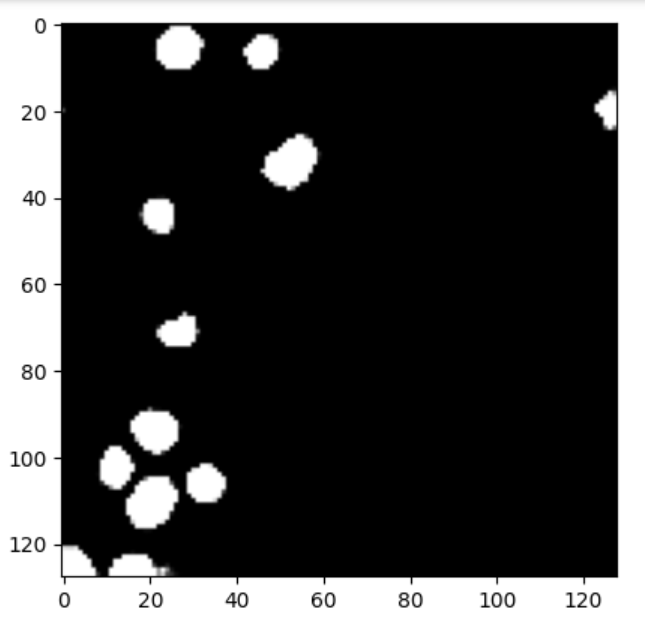

In [3]:
import base64
from IPython.display import HTML

image_path = "/Users/Bader/Pictures/Screenshots/Capture d'écran 2025-01-31 003350.png"

with open(image_path, "rb") as img_file:
    encoded_string = base64.b64encode(img_file.read()).decode("utf-8")

html_code = f'<img src="data:image/png;base64,{encoded_string}" width="500"/>'
display(HTML(html_code))



### Enregistrement de notre image générée :

In [ ]:
X_fake_reshaped = (X_fake[0] * 255).astype(np.uint8).reshape(128, 128)
image = Image.fromarray(X_fake_reshaped, mode='L') 

output_path = os.path.join('/Users/Bader/Desktop/Mines 2A/Projet 2A/Images génerées', 'image1.png')
image.save(output_path)

### On filtre notre image afin de séparer nos clusters :

In [ ]:
image_path = r"/Users/Bader/Desktop/Mines 2A/Projet 2A/Images génerées/image1.png"
with open(image_path, "rb") as f:
    image_data = np.asarray(bytearray(f.read()), dtype=np.uint8)

#On décode l'image
imageenr = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

gray = cv2.cvtColor(imageenr, cv2.COLOR_BGR2GRAY)

smoothed = gaussian_filter(gray,sigma=0.5) #modifier le sigma peut modifier nos séparations

tresh_value = threshold_otsu(smoothed)
binary = (smoothed > tresh_value).astype(np.uint8) * 255

kernel = np.ones((3, 3), np.uint8)
thresh = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

kernel = disk(2) # Attention ! Plus le kernel est petit plus les artefacts seront conservés
binary_opened = binary_erosion(binary, kernel)

distance=distance_transform_edt(binary_opened)
markers=label(distance>0.3*distance.max()) #si on augmente le 0.3 les petits clusters peuvent disparaitre
local_maxi = watershed(-distance,markers,mask=binary_opened)
binary_local_maxi = (local_maxi > 0).astype(np.uint8) * 255
fig,ax= plt.subplots(1,4,figsize=(15,5))

ax[0].imshow(imageenr,cmap='gray') ; ax[0].set_title("image originale")
ax[1].imshow(binary,cmap='gray') ; ax[1].set_title("image seuillée")
ax[2].imshow(thresh,cmap='gray') ; ax[2].set_title("ouverture morphologique")
ax[3].imshow(binary_opened,cmap='gray') ; ax[3].set_title("image clusters réduits")
ax[4].imshow(binary_local_maxi,cmap='nipy_spectral'); ax[4].set_title("image clusters séparés")

plt.show()


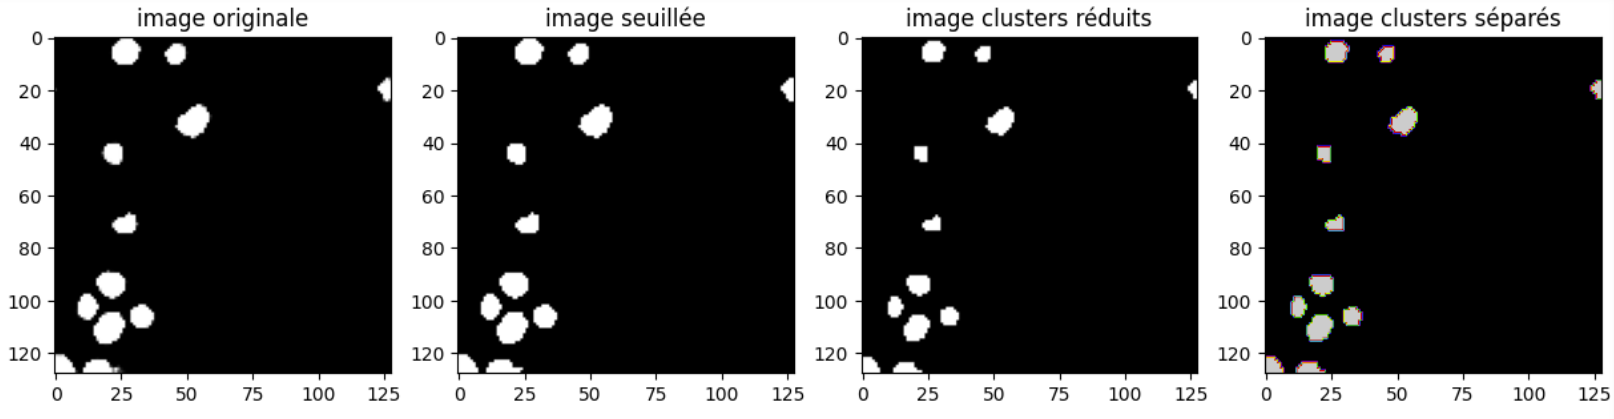

In [5]:
import base64
from IPython.display import HTML

image_path = "/Users/Bader/Pictures/Screenshots/Capture d'écran 2025-01-31 003107.png"

with open(image_path, "rb") as img_file:
    encoded_string = base64.b64encode(img_file.read()).decode("utf-8")

html_code = f'<img src="data:image/png;base64,{encoded_string}" width="1000"/>'
display(HTML(html_code))

### Enregistrement de cette nouvelle image :

In [ ]:
image_bw = Image.fromarray(binary_local_maxi, mode='L')

output_path = os.path.join('/Users/Bader/Desktop/Mines 2A/Projet 2A/Images génerées', 'image2.png')

image_bw.save(output_path)

### Tracé de cercles pour remplacer nos clusters :

In [ ]:
image_path = r"/Users/Bader/Desktop/Mines 2A/Projet 2A/Images génerées/image2.png"

with open(image_path, "rb") as f:
    image_data = np.asarray(bytearray(f.read()), dtype=np.uint8)

#On décode l'image
imageenr = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

H=imageenr.shape[0]
W=imageenr.shape[1]

gray = cv2.cvtColor(imageenr, cv2.COLOR_BGR2GRAY)


#On applique un seuillage
_, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

# ON évite les petits artefacts
kernel = np.ones((3, 3), np.uint8) #pareil modifier le kernel modifie nos artefacts
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

# On trouve les contours des clusters
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Image sur laquelle on dessine les cercles
output = np.zeros_like(image)

# taille fixe des cercles
fixed_radius =imageenr.shape[0]*3.98942280401433*10**(-2) 
fig, ax = plt.subplots()
ax.imshow(output, cmap='gray')

for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"] )
        cy = int(M["m01"] / M["m00"] )
        
        # DOn dessine un cercle de taille fixe centré sur le cluster
        #cv2.circle(output, (cx, cy), fixed_radius, (255, 255, 255), -1)
        circle = plt.Circle((cx, cy), fixed_radius, color='white', fill=True, alpha=0.9)
        ax.add_patch(circle)
        translations = [
            (-W, 0),  # Gauche
            (W, 0),   # Droite
            (0, -H),  # Bas
            (0, H),   # Haut
            (-W, -H), # Coin Bas-Gauche
            (-W, H),  # Coin Haut-Gauche
            (W, -H),  # Coin Bas-Droite
            (W, H)    # Coin Haut-Droite
        ]

        for dx, dy in translations:
            shifted_circle = plt.Circle((cx + dx, cy + dy), fixed_radius, color='white', fill=True, alpha=0.9)
            ax.add_patch(shifted_circle)

#plt.imshow(fig, cmap='gray')
plt.axis()
plt.show()


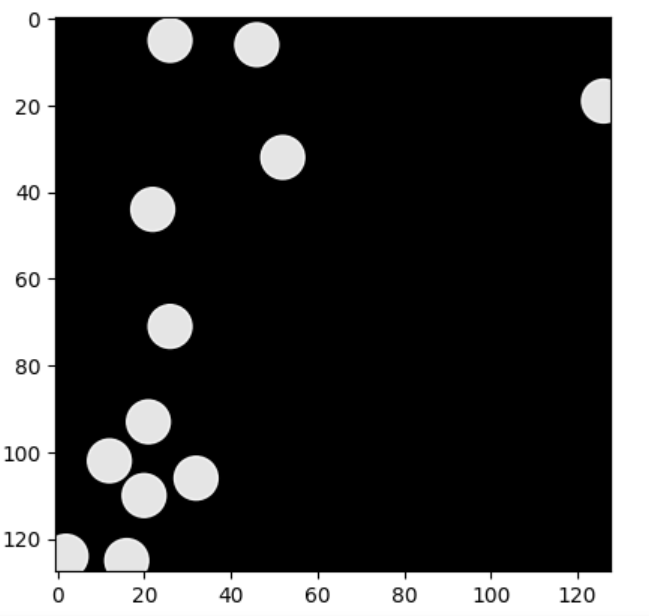

In [6]:
import base64
from IPython.display import HTML

image_path = "/Users/Bader/Pictures/Screenshots/Capture d'écran 2025-01-31 003423.png"

with open(image_path, "rb") as img_file:
    encoded_string = base64.b64encode(img_file.read()).decode("utf-8")

html_code = f'<img src="data:image/png;base64,{encoded_string}" width="500"/>'
display(HTML(html_code))

### Conversion en array :

In [ ]:
dpi = 25
figsize = ( imageenr.shape[0] / dpi, imageenr.shape[1] / dpi)

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.imshow(output, cmap='gray')


for cnt in contours:
    M = cv2.moments(cnt)
    if M["m00"] != 0:
        cx = int(M["m10"] / M["m00"] )
        cy = int(M["m01"] / M["m00"] )
        
        # DOn dessine un cercle de taille fixe centré sur le cluster
        #cv2.circle(output, (cx, cy), fixed_radius, (255, 255, 255), -1)
        circle = plt.Circle((cx, cy), fixed_radius, color='white', fill=True, alpha=0.9)
        ax.add_patch(circle)

        translations = [
            (-W, 0),  # Gauche
            (W, 0),   # Droite
            (0, -H),  # Bas
            (0, H),   # Haut
            (-W, -H), # Coin Bas-Gauche
            (-W, H),  # Coin Haut-Gauche
            (W, -H),  # Coin Bas-Droite
            (W, H)    # Coin Haut-Droite
        ]

        for dx, dy in translations:
            shifted_circle = plt.Circle((cx + dx, cy + dy), fixed_radius, color='white', fill=True, alpha=0.9)
            ax.add_patch(shifted_circle)
ax.set_position([0,0,1,1])

ax.set_xticks([])  
ax.set_yticks([])  
ax.set_frame_on(False)  
ax.set_facecolor('black')

fig.canvas.draw()


image_array = np.array(fig.canvas.renderer.buffer_rgba())  # Récupération en RGBA
plt.close(fig)  # Fermer la figure pour libérer la mémoire
print(image_array.shape)

# Conversion en niveaux de gris et seuillage
gray_image = np.mean(image_array[:H, :W, :3], axis=2)  # Convertir en niveaux de gris
binary_array = gray_image > 100  # Seuil pour obtenir une matrice de 0 et 1
print(binary_array.shape)
# Affichage du résultat
plt.figure()
plt.imshow(binary_array, cmap='gray')
plt.title("Image transformée en binaire")
plt.show()